<a href="https://www.kaggle.com/code/bnzn261029/ed-demand-prediction?scriptVersionId=115329146" target="_blank"><img align="left" alt="Kaggle" title="Open in Kaggle" src="https://kaggle.com/static/images/open-in-kaggle.svg"></a>

In [3]:
import os
from math import sqrt
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, r2_score

# dataverse ed utilization dataset

In [4]:
# Lee, Jarone, 2018, "Emergency Department Utilization Dataset", https://doi.org/10.7910/DVN/EZBGYR, Harvard Dataverse, V1, UNF:6:2pQqwsrwzkdWx9RFq5MIBg== [fileUNF]
df = pd.read_csv("/kaggle/input/harvard-dataverse-ed-utilization-dataset/Blinddata.csv")
df.head()

,yearmonth,clinical_group,diaggroup_specialist,ed_dayofweek,diaggroup_edvis,disposition,ed_related_to_spec,gender,ed_weekday_enc,ed_weekday,ed_workinghours,ed_spec
0,"2016,04",allimm-allergy,Respiratory,Friday,"Kidney, Urinary Tract",Treated and Released,No,F,Yes,Yes,Yes,No
1,"2016,02",allimm-allergy,"Ear, Nose, Mouth, Dental",Monday,Circulatory,Treated and Released,No,M,Yes,Yes,No,No
2,"2016,12",allimm-rheum,Musculoskeletal,Friday,"Ear, Nose, Mouth, Dental",Treated and Released,No,F,Yes,Yes,Yes,No
3,"2016,07",allimm-rheum,"Injuries, Poisoning, Comp",Friday,Musculoskeletal,Treated and Released,No,M,Yes,Yes,No,No
4,"2016,08",allimm-rheum,Musculoskeletal,Friday,"Skin, Breast",Treated and Released,No,F,Yes,Yes,No,No


In [5]:
df.isna().sum()

yearmonth                0
clinical_group           0
diaggroup_specialist     2
ed_dayofweek             0
diaggroup_edvis         93
disposition              0
ed_related_to_spec       0
gender                   2
ed_weekday_enc           0
ed_weekday               0
ed_workinghours          0
ed_spec                  0
dtype: int64

In [6]:
df.describe()

,yearmonth,clinical_group,diaggroup_specialist,ed_dayofweek,diaggroup_edvis,disposition,ed_related_to_spec,gender,ed_weekday_enc,ed_weekday,ed_workinghours,ed_spec
count,36271,36271,36269,36271,36178,36271,36271,36269,36271,36271,36271,36271
unique,12,68,23,7,22,1,2,2,2,2,2,2
top,"2016,01",derm-medical,"Skin, Breast",Monday,Circulatory,Treated and Released,No,F,Yes,Yes,No,No
freq,3571,4326,5321,5540,5135,36271,30107,20388,26841,26841,22457,30107


In [7]:
# drop columns that do not contain additional information
df.drop(["disposition", "ed_weekday_enc"], axis=1, inplace=True)

In [8]:
yearmonth = pd.to_datetime(df.yearmonth, format='%Y,%m')
yearmonth

0       2016-04-01
1       2016-02-01
2       2016-12-01
3       2016-07-01
4       2016-08-01
           ...    
36266   2016-01-01
36267   2016-02-01
36268   2016-03-01
36269   2016-09-01
36270   2016-06-01
Name: yearmonth, Length: 36271, dtype: datetime64[ns]

## almost steady service utilization over the 12 months of 1 year

In [9]:
yearmonth.value_counts().sort_index()

2016-01-01    3571
2016-02-01    3328
2016-03-01    3503
2016-04-01    2720
2016-05-01    2948
2016-06-01    3259
2016-07-01    3084
2016-08-01    3057
2016-09-01    3218
2016-10-01    2794
2016-11-01    2544
2016-12-01    2245
Name: yearmonth, dtype: int64

## peak on monday, less utilization on weekend

In [10]:
df.ed_dayofweek.value_counts()

Monday       5540
Wednesday    5399
Thursday     5379
Tuesday      5307
Friday       5216
Sunday       4728
Saturday     4702
Name: ed_dayofweek, dtype: int64

In [30]:
print(df.ed_weekday.value_counts())
print()
print(df.ed_workinghours.value_counts())

Yes    26841
No      9430
Name: ed_weekday, dtype: int64

No     22457
Yes    13814
Name: ed_workinghours, dtype: int64


In [23]:
df.gender.value_counts()

F    20388
M    15881
Name: gender, dtype: int64

In [12]:
print(df.clinical_group.value_counts(normalize=True)[:5])
print()
print(df.diaggroup_specialist.value_counts(normalize=True)[:5])
print()
print(df.diaggroup_edvis.value_counts(normalize=True)[:])

derm-medical    0.119269
psych-adult     0.067878
card-cua        0.057787
pmrs-general    0.056105
psych-comm      0.039095
Name: clinical_group, dtype: float64

Skin, Breast       0.146709
Mental             0.127795
Circulatory        0.122226
Musculoskeletal    0.103367
Nervous            0.088919
Name: diaggroup_specialist, dtype: float64

Circulatory                  0.141937
Digestive                    0.140334
Musculoskeletal              0.135303
Skin, Breast                 0.084140
Nervous                      0.078832
Respiratory                  0.069711
Ear, Nose, Mouth, Dental     0.063934
Kidney, Urinary Tract        0.055918
Mental                       0.040743
Injuries, Poisoning, Comp    0.038007
Health Status                0.036542
Endocrine, Metabolic         0.031179
Infections                   0.023771
Alcohol / Drug, Abuse        0.014567
Eye                          0.012245
Reproductive                 0.011471
Blood, Immune System         0.007297
Pregnan

In [21]:
list(df.diaggroup_edvis.value_counts(normalize=True)[:].values)

[0.14193708883852066,
 0.14033390458289569,
 0.13530322295317596,
 0.08413953231245508,
 0.07883243960417934,
 0.06971087401183039,
 0.0639338824700094,
 0.05591796119188457,
 0.04074299297915861,
 0.038006523301453925,
 0.03654154458510697,
 0.031179169661120016,
 0.023771352755818452,
 0.014566863839902704,
 0.012245010780032064,
 0.011471059760075184,
 0.007297252473879153,
 0.005998120404665819,
 0.005583503786831776,
 0.0015755431477693625,
 0.0008568743435236884,
 5.5282215711205703e-05]

# NHS emergency services data 2019-2021

In [39]:
# https://digital.nhs.uk/data-and-information/publications/statistical/hospital-accident--emergency-activity/2020-21
# https://files.digital.nhs.uk/73/5F1B2A/AE2021_Summary_Report_Tables.xlsx
! wget https://files.digital.nhs.uk/5C/702A3E/AE2021_National_Data_Tables.xlsx
! wget https://files.digital.nhs.uk/19/784CD0/AE2021%20Provider%20Level%20Tables.xlsx
# https://files.digital.nhs.uk/3C/68AC3E/AE2021%20Home%20Nations%20Comparison.xlsx
! wget https://files.digital.nhs.uk/0D/BEF8FE/AE2021%20acci-emer-workforce-data.xlsx
! wget https://files.digital.nhs.uk/34/8D6662/AE2021_DQ_comparison_4hour_ECDS_MSitAE.xlsx
! wget https://files.digital.nhs.uk/81/9C0757/AE2021_CQI_Open_Data.csv
# https://files.digital.nhs.uk/AB/522485/AE2021%20Weekly%20variation%20attendances%20during%20pandemic%20open%20data.csv
# https://files.digital.nhs.uk/80/623887/AE2021%20Metadata.xlsx

--2022-12-31 14:50:49--  https://files.digital.nhs.uk/5C/702A3E/AE2021_National_Data_Tables.xlsx
Resolving files.digital.nhs.uk (files.digital.nhs.uk)... 18.65.39.6, 18.65.39.111, 18.65.39.59, ...
Connecting to files.digital.nhs.uk (files.digital.nhs.uk)|18.65.39.6|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 6541809 (6.2M) [application/vnd.openxmlformats-officedocument.spreadsheetml.sheet]
Saving to: ‘AE2021_National_Data_Tables.xlsx’

AE2021_National_Dat 100%[===================>]   6.24M  25.1MB/s    in 0.2s    

2022-12-31 14:50:50 (25.1 MB/s) - ‘AE2021_National_Data_Tables.xlsx’ saved [6541809/6541809]

--2022-12-31 14:50:51--  https://files.digital.nhs.uk/19/784CD0/AE2021%20Provider%20Level%20Tables.xlsx
Resolving files.digital.nhs.uk (files.digital.nhs.uk)... 18.65.39.111, 18.65.39.6, 18.65.39.121, ...
Connecting to files.digital.nhs.uk (files.digital.nhs.uk)|18.65.39.111|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 23470

In [75]:
for i in range(1,99):
    try:
        print(list(pd.read_excel("/kaggle/working/AE2021_National_Data_Tables.xlsx", sheet_name=i, skiprows=1, nrows=1))[0])
    except:
        break

Accident and Emergency Annual Report 2020-21: Table of contents
Table 1: Attendances Recorded by Type in A&E HES/ECDS and A&E MSitAE, 
2018-19 to 2020-21 (HES/ECDS) and (MSitAE)
Table 2: Number of Valid Records by A&E Key Field, 2020-21 (ECDS)
Table 3: Comparison of 2019-20 and 2020-21 Unplanned A&E Attendances in ECDS against those reported in MSitAE, broken down by the Organisation Type (HES/ECDS) and (MSitAE)
Table 4: A&E Attendances by Attendance Category, 2019-20 and 2020-21 (HES/ECDS)
Table 5: A&E Attendances by Gender, 2019-20 and 2020-21 (HES/ECDS)
Table 6: A&E Attendances by Age Group, 2019-20 and 2020-21 (HES/ECDS)
Table 7: A&E Attendances by Gender and Age Group, 2019-20 and 2020-21 (HES/ECDS)
Table 8: A&E Attendances by Month, 2019-20 and 2020-21 (HES/ECDS)
Table 9: A&E Attendances by Day, 2019-20 and 2020-21 (HES/ECDS)
Table 10: A&E Attendances by Attendance Source, 2020-21 (ECDS)
Table 11: A&E Attendances by Arrival Mode, 2019-20 and 2020-21 (HES/ECDS)
Table 12: A&E Atten

## as in the us dataset: almost steady utilization over the months

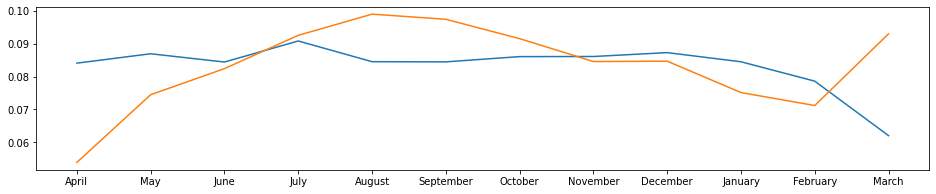

In [121]:
month = pd.read_excel("/kaggle/working/AE2021_National_Data_Tables.xlsx", sheet_name=9, skiprows=6, nrows=12)

plt.figure(figsize=(16,3))
plt.plot(month.iloc[:,0], month[["% of total attendances", "% of total attendances.1"]])
plt.show()

## again: peak on monday, less demand on weekend

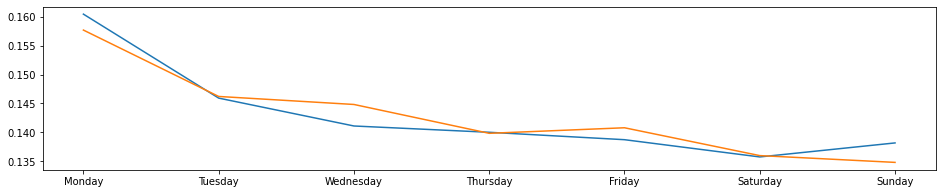

In [104]:
day = pd.read_excel("/kaggle/working/AE2021_National_Data_Tables.xlsx", sheet_name=10, skiprows=6, nrows=7)

plt.figure(figsize=(16,3))
plt.plot(day.Day, day[["% of total attendances", "% of total attendances.1"]])
plt.show()

## highest demand during working hours and continuing to evening 

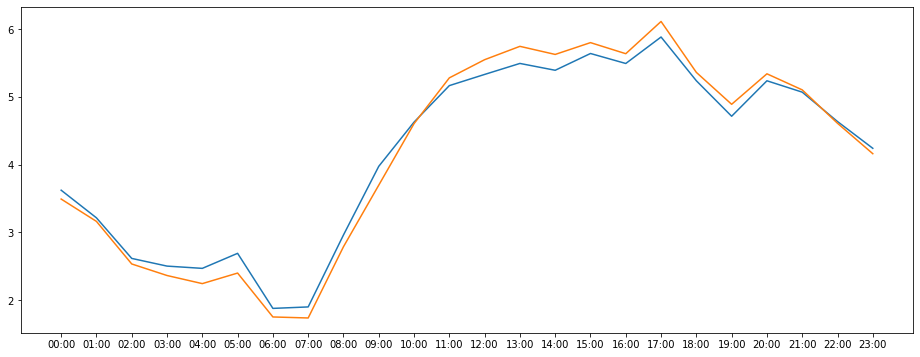

In [148]:
hours = pd.read_excel("/kaggle/working/AE2021_National_Data_Tables.xlsx", sheet_name=13, skiprows=6, nrows=24)

plt.figure(figsize=(16,6))
plt.plot(hours["Arrival hour"], 
         (hours["Number of A&E attendances that arrived by ambulance"])*100/sum(hours["Number of A&E attendances that arrived by ambulance"]))
plt.plot(hours["Arrival hour"], 
         (hours["Number of A&E attendances that arrived by ambulance.1"])*100/sum(hours["Number of A&E attendances that arrived by ambulance.1"]))
plt.show()

In [128]:
for i in range(1,99):
    try:
        print(list(pd.read_excel("/kaggle/working/AE2021 acci-emer-workforce-data.xlsx", sheet_name=i, skiprows=1, nrows=1))[0])
    except:
        break

Table 1a: Full Time Equivalent (FTE) Figures for Doctors (excluding Consultants), 2020-21
Table 1b: Full Time Equivalent (FTE) Figures for Consultants, 2020-21
Table 1c: Full Time Equivalent (FTE) Figures for Nurses, 2020-21
Table 1d: Full Time Equivalent (FTE) Figures for Care Providers, 2020-21
Table 2: Stability Index of Staff for NHS Trusts, 2020-21


# evaluating linear regression models

Root Mean squared error with PolynomialFeatures set to 1 degrees: 0.99
Root Mean squared error with PolynomialFeatures set to 2 degrees: 1.41
Root Mean squared error with PolynomialFeatures set to 3 degrees: 0.55
Root Mean squared error with PolynomialFeatures set to 4 degrees: 0.72
Root Mean squared error with PolynomialFeatures set to 5 degrees: 0.58
Root Mean squared error with PolynomialFeatures set to 6 degrees: 1.79


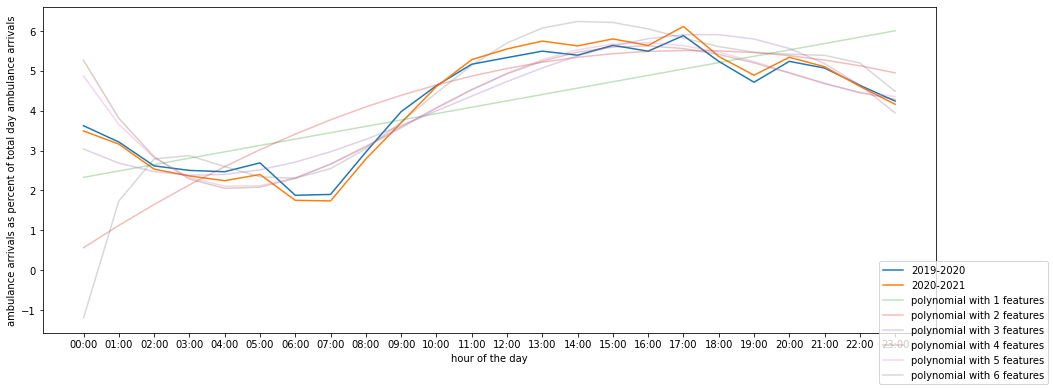

In [219]:
from sklearn.preprocessing import PolynomialFeatures

fig = plt.figure(figsize=(16,6))

plt.plot(hours["Arrival hour"], 
         (hours["Number of A&E attendances that arrived by ambulance"])*100/sum(hours["Number of A&E attendances that arrived by ambulance"]),
         label="2019-2020")
plt.plot(hours["Arrival hour"], 
         (hours["Number of A&E attendances that arrived by ambulance.1"])*100/sum(hours["Number of A&E attendances that arrived by ambulance.1"]),
         label="2020-2021")

for i in range(1,7):

    poly_feat = PolynomialFeatures(i)

    X_trian, X_test, y_train, y_test = train_test_split(np.array(range(24)).reshape(-1, 1),
                                                       (hours["Number of A&E attendances that arrived by ambulance"])*100/sum(hours["Number of A&E attendances that arrived by ambulance"]),
                                                       test_size=0.3, random_state=42)

    X_train = poly_feat.fit_transform(X_trian)
    X_test = poly_feat.fit_transform(X_test)

    from sklearn import linear_model
    lr_model= linear_model.LinearRegression()

    # training the model on traning set
    lr_model.fit(X_train, y_train)

    # make the prediction
    y_pred = lr_model.predict(X_test)
    rmse = sqrt(mean_squared_error(y_test, y_pred))
    #root mean squared error
    print("Root Mean squared error with PolynomialFeatures set to", i, "degrees: %.2f" 
          % sqrt(mean_squared_error(y_test, y_pred)))
    
    pred_abs = lr_model.predict(poly_feat.fit_transform(np.array(range(24)).reshape(-1, 1)))
    pred_rel = pred_abs*100/sum(pred_abs)

    plt.plot(hours["Arrival hour"], 
             pred_rel,
             label=f"polynomial with {str(i)} features",
             alpha=0.3)

fig.legend(loc="lower right")
plt.xlabel("hour of the day")
plt.ylabel("ambulance arrivals as percent of total day ambulance arrivals")
plt.show()

# best model: 3rd degree polynomial regression

In [220]:
poly_feat = PolynomialFeatures(3)

X_trian, X_test, y_train, y_test = train_test_split(np.array(range(24)).reshape(-1, 1),
                                                       (hours["Number of A&E attendances that arrived by ambulance"])*100/sum(hours["Number of A&E attendances that arrived by ambulance"]),
                                                       test_size=0.3, random_state=42)

X_train = poly_feat.fit_transform(X_trian)
X_test = poly_feat.fit_transform(X_test)

from sklearn import linear_model
lr_model= linear_model.LinearRegression()

# training the model on traning set
lr_model.fit(X_train, y_train)

LinearRegression()

In [222]:
lr_model.coef_, lr_model.intercept_

(array([ 0.        , -0.41917051,  0.07538841, -0.00241279]),
 2.976047189345115)

In [236]:
arrivals_per_day = 60 # regardless of ambulance or other mean of transportation
# day_hour = 5 

for i in range(24):
    day_hour = i
    x = day_hour
    _, a, b, c = lr_model.coef_
    intercept = lr_model.intercept_
    y = a*x**1 + b*x**2 + c*x**3 + intercept
    print(f"From {day_hour}:00 to {day_hour+1}:00 there will be {int(y)} arrivals.")

From 0:00 to 1:00 there will be 2 arrivals.
From 1:00 to 2:00 there will be 2 arrivals.
From 2:00 to 3:00 there will be 2 arrivals.
From 3:00 to 4:00 there will be 2 arrivals.
From 4:00 to 5:00 there will be 2 arrivals.
From 5:00 to 6:00 there will be 2 arrivals.
From 6:00 to 7:00 there will be 2 arrivals.
From 7:00 to 8:00 there will be 2 arrivals.
From 8:00 to 9:00 there will be 3 arrivals.
From 9:00 to 10:00 there will be 3 arrivals.
From 10:00 to 11:00 there will be 3 arrivals.
From 11:00 to 12:00 there will be 4 arrivals.
From 12:00 to 13:00 there will be 4 arrivals.
From 13:00 to 14:00 there will be 4 arrivals.
From 14:00 to 15:00 there will be 5 arrivals.
From 15:00 to 16:00 there will be 5 arrivals.
From 16:00 to 17:00 there will be 5 arrivals.
From 17:00 to 18:00 there will be 5 arrivals.
From 18:00 to 19:00 there will be 5 arrivals.
From 19:00 to 20:00 there will be 5 arrivals.
From 20:00 to 21:00 there will be 5 arrivals.
From 21:00 to 22:00 there will be 5 arrivals.
From 22

In [ ]:
# add more time features: week of day, season, holiday

# simpy

process-based discrete-event simulation

https://simpy.readthedocs.io/

In [2]:
! pip install simpy

In [9]:
a, b, c = [-0.41917051,  0.07538841, -0.00241279]
intercept = 2.976047189345115

demand_per_hour = [round((a*hour**1 + b*hour**2 + c*hour**3 + intercept)*(60/100)) for hour in range(24)]
demand_per_hour

[2, 2, 1, 1, 1, 1, 2, 2, 2, 2, 2, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 3, 2]

In [11]:
import random
import simpy

RANDOM_SEED = 42
CAPACITY = 10
DURATION = 4
ARRIVAL_TIME = 1
SIM_TIME = 25

class Emergency_Department(object):
    def __init__(self, env, capacity, duration):
        self.env = env
        self.capacity = simpy.Resource(env, capacity)
        self.duration = duration

    def care(self, patient):
        yield self.env.timeout(random.randrange(DURATION-2, DURATION+3))

def patient(env, name, ed):
    arrival_time = env.now
    
    print('%s arrives at %d:00' % (name, env.now))
    with ed.capacity.request() as request:
        yield request

        yield env.process(ed.care(name))

        print('%s leaves at %d:00, (time spent %d hours)' % (name, env.now, env.now - arrival_time ))

def setup(env, capacity, duration, arrival_time):
    ed = Emergency_Department(env, capacity, duration)

    i = 0
    
    for el in demand_per_hour:
        yield env.timeout(1)
        for _ in range(el):
            i += 1
            env.process(patient(env, 'Patient %d' % i, ed))


random.seed(RANDOM_SEED)  # This helps reproducing the results

env = simpy.Environment()
env.process(setup(env, CAPACITY, DURATION, ARRIVAL_TIME))

env.run(until=SIM_TIME)

Patient 1 arrives at 1:00
Patient 2 arrives at 1:00
Patient 3 arrives at 2:00
Patient 4 arrives at 2:00
Patient 5 arrives at 3:00
Patient 1 leaves at 3:00, (time spent 2 hours)
Patient 2 leaves at 3:00, (time spent 2 hours)
Patient 6 arrives at 4:00
Patient 7 arrives at 5:00
Patient 4 leaves at 5:00, (time spent 3 hours)
Patient 8 arrives at 6:00
Patient 3 leaves at 6:00, (time spent 4 hours)
Patient 5 leaves at 6:00, (time spent 3 hours)
Patient 9 arrives at 7:00
Patient 10 arrives at 7:00
Patient 6 leaves at 7:00, (time spent 3 hours)
Patient 7 leaves at 7:00, (time spent 2 hours)
Patient 11 arrives at 8:00
Patient 12 arrives at 8:00
Patient 13 arrives at 9:00
Patient 14 arrives at 9:00
Patient 9 leaves at 9:00, (time spent 2 hours)
Patient 15 arrives at 10:00
Patient 16 arrives at 10:00
Patient 12 leaves at 10:00, (time spent 2 hours)
Patient 17 arrives at 11:00
Patient 18 arrives at 11:00
Patient 13 leaves at 11:00, (time spent 2 hours)
Patient 14 leaves at 11:00, (time spent 2 hou